# Gaussian processes
In our group we mostly use Gaussian processes to do interpolation, or creating a model for some kind of data without having an explicit functional form such as a line, quadratic, or periodic function. This is in contrast to the examples in the Model Fitting directory, where we fit data with generative models that we specified at the start of each exercise.

In this example we will try to model the same data we used in the Hogg2010 exercises.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
plt.rc("font", size=20)
%matplotlib inline
import george
import george.kernels as kernels

<Container object of 3 artists>

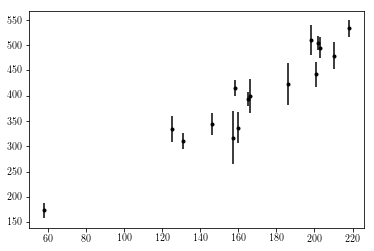

In [2]:
#First we fetch the data
data = np.genfromtxt("data.txt", skip_header=1, delimiter='&')

#These functions return the different parts of the
#Hogg data, specifically the 'good' and 'bad' sections.
def good_data():
    return data[4:,1:4].T

def bad_data():
    return data[:4, 1:4].T

def all_data():
    return np.concatenate((bad_data().T, good_data().T)).T

x, y, yerr = good_data()
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')

## Building a GP
A GP is built on two things: the kernel and the observations. The kernel is the tool that specifies the covariance between all your observations. The observations are just a set of data points, so $x$ and $y$ values (where $x$ may be multi-dimensional).

We will use the most common kernel called the Squared Exponential kernel.
$$k(x_i,x_j) = k_0\exp\left(-\frac{(x_i-x_j)^2}{2\sigma^2}\right). $$
This kernel has two free parameters, the overall variance $k_0$ and the "kernel length" $\sigma$. In `george` the `ExpSquaredKernel` is implemented without $k_0$, but we can multiply on a constant kernel to achieve this. These are called hyperparameters in machine learning lingo.

In [3]:
kernel = kernels.ConstantKernel(1.0)*kernels.ExpSquaredKernel(1.0)
gp = george.GP(kernel)
gp.compute(x, yerr)
op_result = gp.optimize(x, y, yerr)

Optimization terminated successfully.


## Training the GP
Once the kernel is specified and the GP object is created, we start by pre-computing the covariance matrix ones by calling `gp.compute()`. Next, we can call `george`'s built-in optimization routine (which is not very advanced), to find a good set of hyperparameters. A more mature analysis should utilize a statistical analysis of the hyperparameters using an MCMC.

## Using the GP
With the GP properly trained on the data (meaning we have good hyperparameters), we can now use it to make predictions. The `predict()` function gives us a mean prediction and the covariance between all those points, while the `sample_conditional()` function makes a 'realization' of the curve. In this example the prediction is in red, with the one $1\sigma$ region filled in as well as ten realizations of the curve.

/home/tom/anaconda2/lib/python2.7/site-packages/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


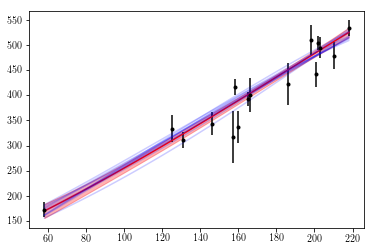

In [4]:
d = np.linspace(min(x), max(x), 100)
mu, cov = gp.predict(y, d)
err = np.sqrt(np.diag(cov))
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)
for i in range(10):
    plt.plot(d, gp.sample_conditional(y,d), c='b', alpha=0.2)

## Bad data = bad GP
In the Hogg exercises we saw that having bad data means that our generative model will fail, and we would need something more complicated. The same is true here - if we have data that we *think* we trust but is actually junk, then the GP will do its best but in reality not make much sense.

Optimization terminated successfully.


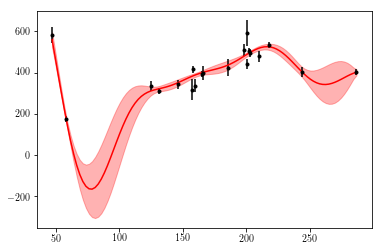

In [5]:
x, y, yerr = all_data()
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
kernel = kernels.ConstantKernel(1.0)*kernels.ExpSquaredKernel(1.0)
gp = george.GP(kernel)
gp.compute(x, yerr)
op_result = gp.optimize(x, y, yerr)
d = np.linspace(min(x), max(x), 100)
mu, cov = gp.predict(y, d)
err = np.sqrt(np.diag(cov))
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)

The GP is fitting **all** the data now, including the bad stuff at high and low $x$. The first GP looked sensible and suggested a model for a data: a line, and that we could use that instead of a GP. This second GP is trying its best to fit all the data. This is both an advantage and a disadvantage, since the GP can give *a* model despite bad data, but that model might not be what you wanted to use in the end.